# Project: Final Fantasy XIV
Webpage: https://rasim-deniz.github.io/final-fantasy-14/

## 1. Motivation

The Final Fantasy series had an incredible effect on the gaming world. Developed by Square Enix and released for the Nintendo Entertainment System (NES) in 1987, the game was considered an outlier at the time: games had simplistic plots and little to no character development. For this reason, the game was named "Final Fantasy," as the game's director thought it would be a failure for being too strange at the time and would end his career. 

However, history differed from expectations. Known for its rich lore, deep interactions between characters, and outstanding music, the series changed the role-playing genre forever. The Final Fantasy series became an international hit, selling more than 164 million units worldwide as of October 2021.

Out of all the 95 Final Fantasy games, we chose Final Fantasy XIV for the following reasons:
* It is the latest massive multiplayer online role-playing game, which has a relatively large number of characters, clans, and races.
* The wiki is well documented and detailed.
* Non-linear storyline, an interesting contrast to the Zelda network.

The final goal of this project is to understand the game's characters and world better through network and text analysis,  comprehend how the characters are related to each other, and see the importance of the characters in their respective communities along with thier sentiment.


## 2. Data

We analyzed two datasets for Final Fantasy XIV:

**1. The fan wiki of Final Fantasy XIV**

The [Final Fantasy XIV](https://finalfantasy.fandom.com/wiki/Final_Fantasy_XIV_characters)'s wiki was used to download all characters' descriptions and attributes. 

The data was extracted using the fandom wiki's API and stored in JSON. Regular expressions were utilized to extract the description of each character along with the attributes of interest: race and affiliation. Other attributes were also extracted: gender, age, and occupation.

**2. The game's dialogue**

All the [dialogue between characters](https://docs.google.com/document/d/1wlFBfhu7wjHlMEVSEZgEHpaaJIQBhrmh-RIdWYGMJZM/edit#heading=h.qix0vfb9xzle) was obtained for text and sentiment analysis to explore the game's characters world through text interactions.

#### Data Preprocessing

Our strategy was to use regular expressions that have more false positives than false negatives and then clean the edge cases manually based on our knowledge of the dataset. The following data preprocessing was performed:

* **Duplicates Removal**: Some characters are referred to using different names in the wiki. This was detected and fixed by keeping only the unque characters.
* **Redirects Handling**: The redirects were detected using a regular expression, then the correct character pages were manually hard-coded to refer to the right link
* **Class Re-Assignment**: Some classes have different synonyms. For instance, the race "hume" is the same as "hyur." This was fixed by re-assigning the same categories in such cases.
* **Regex Fixing**: Edge cases in which our regular expressions obtained false positives and negatives were fixed manually by assigning the false values to the correct ones. 

For text analysis, the following was performed:
* **Stop Words and Punctuation Removal**: Common stop words and punctuation were deleted so that the text analysis is not influenced by it
* **Tokenization and Lemmatization**: The text was tokenized and lemmatized in the dialogue and for each character. 

#### Data Statistics:
 
* **Number of characters**: 385

* **Total data size**: 3.21 MB

* **Number of links (Directed)**: 1477

* **Number of links (Undirected)**: 1131

* **Most common characters (in-degree)**: Alphinaud Leveilleur, 56

* **Most common characters (out-degree)**: Alphinaud Leveilleur, 33


## 3. Tools, theory and analysis

Further commentary and analysis is embeded between code blocks: it is better to show figures and tables together with the explainations.

**Goal 1**: Extract the data from the wiki and store it into JSON containers Get the following attributes: Race, Gender, Age, Occupation, and Affiliation for each character.

**Strategy**:
* Load the JSON content using python libraries and the Final Fantasy fandom wiki's API
* Extract the description of each character and store it on the hard drive for easier access
* Extract Race Gender Occupation Affiliation Age (attributes) using the appropriate regex
     - if not found, assign "Unknown"
* Save the attributes data 
* Save to file for easy future extraction

**Goal 2:** Build a directed network to understand:
* Relations between characters
* The network itself (type by degree: random? scale-free?)
* Compare to a random network

**Strategy:**
* Read the CSV file that has the data into a dataframe
* Build an unconnected network; nodes are the characters with their attributes
* Add the directed edges to the network
* Discard isolated nodes
* Extract GCCs
* Analyze the network's degree 
* Analyze the network's type graphically with the degree distributions, and numerically with the powerlaw function
* Construct a random network of the probability

**Goal 3**: Represent the network graphically and analyze the resultant graph for insights

**Strategy**:

* Use an undirected network
* Utilize ForceAtlas2 algorithm to create the network graph
* Scale the node size based on the degree

**Goal 4:** Analyze text information from the characters:
* Analyze the most common words in the game
* Plot the wordclouds for each Affiliation

**Strategy:**
* Use Regular expressions to clean the text and elimnate unrelated words.
*  Tokenize the text
* Set everything to lower case
* Exclude punctuation and stop words.
* Exclude characters names (since we're interested in the words, not the names)
* Exclude words related to the videogame, not the characters (since we're interested in the words, not the names)
* Lemmatize your words with WordNetLemmatizer()
* Save the text in a dataframe and as txt file
* Plot the cumulative graph of the most common words in the game

**Goal 5**: Analyze the word cloud for some groups of characters

**Strategy**: 
* Obtain the 3 greatest Affiliations and the characters who belong to them.
* Calculate the TF and TF-IDF values for each affiliation
* Analyze the wordcloud over the text previously obtained.


**Goal 6**: Detect and analyze communities in the network

**Strategy**:
* Apply the Louvain Algorithm to the network
* Apply the TF and TF-IDF algorithm to the text of the characters in each community
* Perform sentiment analysis over the characters

**Goal 7**: Perform sentiment analysis over the community

**Strategy**: 
* Collect and preprocess dialogues from the game
* Try both LabMT and VADER analyses on the text data collected from the wiki pages and on the dialogues 


**Note:** The Discussion and Contributions sections are located at the end of this notebook.

In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import re
import math
import json
import string
import urllib
import random
import os
import codecs
from collections import OrderedDict, Counter
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw
from fa2 import ForceAtlas2
import igraph
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import heapq
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, PlaintextCorpusReader
import community.community_louvain as community_louvain
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

random.seed(123) #For reproducibility of the results
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
plt.style.use('seaborn-whitegrid')

### 3.1. Data Extraction and Preprocessing

This project's data consists of two primary sets: the game's fan wiki pages that correspond to descriptions of each character, and the dialogue between characters in the game. The first was used to construct the network and analyze its properties, while the latter was used mainly for text and sentiment analysis based on the extracted communities.

**Goal**: Extract the data from the wiki and store it into JSON containers Get the following attributes: Race, Gender, Age, Occupation, and Affiliation for each character.

**Strategy**:
* Load the JSON content using python libraries and the Final Fantasy fandom wiki's API
* Extract the description of each character and store it on the hard drive for easier access
* Extract Race Gender Occupation Affiliation Age (attributes) using the appropriate regex
     - if not found, assign "Unknown"
* Save the attributes data 
* Save to file for easy future extraction

Since the generated regular expressions are imperfect, our strategy was to err on the side of capturing more terms (more false positives). The captured wrong cases are handled manually. This approach ensures that the probability of missing accurate captures is minimized.


We begin by implementing cleaning and extraction "helper functions." These were written to avoid repetitive and long code blocks when extracting and cleaning the data, as these functions are more generalized and can be utilized in other datasets after minor edits. Each function has a [docstring](https://www.python.org/dev/peps/pep-0257/) that describes the purpose of the function, its input and output.

In [3]:
#Helper functions for Data Extraction and Preprocessing

def get_df(path, attributes=["Name","Race", "Gender","Occupation", "Affiliation","Age"]):
    """
    Load Latest CSV from "path". Attributes are the columns that will be kept
    Return: Pandas datafromwith the selected attributes
    """
    #Comment out attributes that are not needed
    df = pd.read_csv(path)

    #Check if attributes are no longer needed
    for col in df.columns:
        if col not in attributes:
            df = df.drop(columns=col)
    return df

def get_query(t):
    """
    Form the query link
    Input a title to extract a query from the Finalfantasy wiki
    Return: a query link
    """
    baseurl = "https://finalfantasy.fandom.com/api.php?"
    action = "action=query"
    title = f"titles={t}"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    return query

def get_wiki(q):
    """
    Make a JSON object
    Input: A query link (JSON format is expected)
    Return: A JSON object (dictionary) of the query
    """
    wikiresponse = urllib.request.urlopen(q)
    wikitext = wikiresponse.read().decode("utf-8")
    wikijson = json.loads(wikitext)
    return wikijson

def get_json_content(wiki_json):
    """
    Extract the content's string from JSON
    Input:A JSON object (dictionary) of the query
    Return: The "content" of the json object (str)
    """
    part = wiki_json["query"]["pages"]
    #Get unique pageid
    magic = "".join(list(part.keys()))
    #Get only content of json:
    full = part[magic]["revisions"][0]["slots"]["main"]["*"]
    return full

def remove_dups(char_l, print_stats=True):
    """
    Remove duplicated characters (preserve order of the list)
    Input: List of characters
    Return: List of characters without duplicates
    """
    char_cln = list(OrderedDict.fromkeys(char_l).keys())
    if print_stats:
        print("# of chars before removing dups:", len(char_l))
        print("# of chars after removing dups:", len(char_cln))
    return char_cln

def fix_regex(char_l):
    """
    Fix regex edge cases for character selection
    Input: list of characters
    Return: a list of characters with fixed edge cases
    """
    index = char_l.index("Typhon]] and [[Ultros")
    char_l[index] = 'Typhon'
    char_l.append('Ultros')
    char_l.append('Garuda (Final Fantasy XV summon)')
    char_l.append('Marcelloix (Ishgard)')
    char_l.append('Joacin Charlemend Francel de Haillenarte')
    char_l.remove('Lunafreya Nox Fleuret/Final Fantasy XIV')
    return char_l

def fix_redirects(char_l):
    """
    Deal with redirects to other char names
    Input: list of characters
    Return: list of characters with redirects fixed 
    """
    redirects={}
    redirects={"Hilda the Mongrel":'Hilda Ware',
            'Ellie':'Ellie Ryse',
            'Bajsaljen':'Bajsaljen Ulgasch', 
            'Odin (Final Fantasy XIV boss)':'Odin (Final Fantasy XIV)',
            'The Final Coil of Bahamut - Turn 3':'Final Coil of Bahamut - Turn 3',
            'Yatsurugi no Yuki': 'Yuki Yatsurugi',
            'Tsubame Sunrise': 'Tsubame Oshidari',
          'Mide Hotogo': 'Mide Hotgo',
          'The Binding Coil of Bahamut - Turn 5': 'Binding Coil of Bahamut - Turn 5',
          'Lucia goe Junius': 'Lucia Junius',
          'Hilda the Mongrel':'Hilda Ware',
          'Francel de Haillenarte':'Joacin Charlemend Francel de Haillenarte',
          'Basch van Gabranth':'Emet-Selch',
          'Jessie (Final Fantasy XIV)':'Jessie Jaye',
          'Cid nan Garlond':'Cid Garlond',
          'Garuda (Final Fantasy XV)':'Garuda (Final Fantasy XV boss)',
           'Marcelloix':'Marcelloix (Gridania)',
           'Joacin':'Brother Joacin'
          }
    #Fix the redirections
    for i in redirects:
        index = char_l.index(i)
        char_l[index] = redirects[i]
    return char_l

In [4]:
#Get the full data set
title = "Final_Fantasy_XIV_characters"
wiki_json = get_json_content(get_wiki(get_query(title)))

#Prepare regex to get character names:
char_pattern = r"'''\[\[(.*?)(?:#.*?)?(?:\|.*?)?\]\]'''"
char_match = re.findall(char_pattern, wiki_json)


In [5]:
#Remove Duplicates
char_cln = remove_dups(char_match, print_stats=False)

In [6]:
#Fix edge cases and regex errors
final_char = fix_regex(char_cln)
final_char = fix_redirects(final_char)
final_char = remove_dups(final_char)

# of chars before removing dups: 387
# of chars after removing dups: 385


In [7]:
#Save characters to harddrive
for char in final_char:
    with open(f"./files/ff14_chars_json/{char}.txt", "w", encoding="utf-8") as fd:
        char_nospace = char.replace(" ", "_")
        q = get_query(char_nospace)
        w = get_wiki(q)
        json_content = get_json_content(w)
        fd.write(json_content)

In [8]:
#Combine the data in a CSV file and save to harddrive
#User has the option to save certain attributes only by commenting out the unneeded attributes from the list below
attributes = [
    "Name",
    "Race", 
    "Gender",
    "Occupation", 
    "Affiliation", 
    "Age"
]

df = pd.DataFrame(columns=attributes)
df["Name"] = final_char
df.to_csv("./files/characters.csv", index=False)

The code is written in such a way that allows selecting specific attributes rather than the entire dataset. The selection is made by commenting out any of the attributes to remove them from the dataset storage. In our case, we elected to store all the attributes to facilitate accessibility in case further analysis is needed.

In [9]:
#Read the characters from the CSV. No need to re-run the previous cells after the CSV is created
path="./files/characters.csv"
attributes = [
    "Name",
    "Race", 
    "Gender",
    "Occupation", 
    "Affiliation", 
    "Age"
]

df = get_df(path, attributes)

In [10]:
race_pat1   = r"\|\s*race\s*= *[A-Z]+(?:\w+ )+\[{1,}(.*?)\]{1,}" #capture |race=Highlander [[Hyur]]
race_pat2   = r"\|\s*race\s*= *(?:\[{1,})?(.*?)(?:[^a-zA-Z0-9_'\- ])" #capture everything else
gender_pat  = r"\|\s*gender\s*= *(Male|Female)"
age_pat     = r"\|\s*age\s*= *(\d+)"
occ_pat1    = r"\|\s*occupation\s*= *(?:\[{1,}).*?\|(.*?)(?:\]{1,})"
occ_pat2    = r"\|\s*occupation\s*= *(?:\[{1,})?([A-Za-z0-9' ]+)"
aff_pat     = r"\|\s*affiliation\s*= *([\w' ]*)"

#Extract attributes and assign to each chars
for char in df.Name:
     with open(f"./files/ff14_chars_json/{char}.txt", "r", encoding="utf-8") as f:
            node_desc = f.read()
            
            #race
            race1 = ''.join(re.findall(race_pat1, node_desc)).strip()
            race2 = ''.join(re.findall(race_pat2, node_desc)).strip()
            if race1:
                race = race1
            else:
                if race2:
                    race = race2
                else:
                    race = "Unknown"
            #clean up races categories (messy source):
            compounds = ["Elezen", "Hyur"]
            for r in compounds:
                if r in race and " " in race:
                    race = r
            messy = {
                "Half-":"Hyur",
                "Mystel":"Miqo'te",
                "Hume":"Hyur",
                "Drahn":"Au Ra"
            }
            if race in messy:
                race = messy[race]
            #assign the race to char
            df.loc[df.Name == char, "Race"] = race  
            
            #gender:
            gender = ''.join(re.findall(gender_pat, node_desc)).strip()
            df.loc[df.Name == char, "Gender"] = gender if gender else "Unknown"
            
            #age:
            age = ''.join(re.findall(age_pat, node_desc)).strip()
            df.loc[df.Name == char, "Age"] = age if age else "Unknown"
            
            #occupation
            occ1 = ''.join(re.findall(occ_pat1, node_desc)).strip()
            occ2 = ''.join(re.findall(occ_pat2, node_desc.replace("[",""))).strip()
            if occ1:
                occ = occ1
            else:
                if occ2:
                    occ = occ2
                else:
                    occ = "Unknown"
            df.loc[df.Name == char, "Occupation"] = occ
            
            #affiliation:
            node_clean = node_desc.replace("[","")
            node_clean = node_clean.replace("]","")
            aff = ''.join(re.findall(aff_pat, node_clean)).strip()
            df.loc[df.Name == char, "Affiliation"] = aff if aff else "Unknown"

df.to_csv('./files/characters_with_attributes.csv')

In [11]:
df.describe()

,Name,Race,Gender,Occupation,Affiliation,Age
count,385,385,385,385,385,385
unique,385,43,3,131,121,51
top,A-Towa-Cant,Hyur,Male,Unknown,Unknown,Unknown
freq,1,111,222,204,155,244


There are 43 unique races in the game, indicating a diverse world of different types of groups. This will be interesting to see in our community analysis section. 

### 3.2. Network Creation and Analysis

**Goal:** Build a directed network to understand:
* Relations between characters
* The network itself (type by degree: random? scale-free?)
* Compare to a random network

**Strategy:**
* Read the CSV file that has the data into a dataframe
* Build an unconnected network; nodes are the characters with their attributes
* Add the directed edges to the network
* Discard isolated nodes
* Extract GCCs
* Analyze the network's degree 
* Analyze the network's type graphically with the degree distributions, and numerically with the powerlaw function
* Construct a random network of the probability

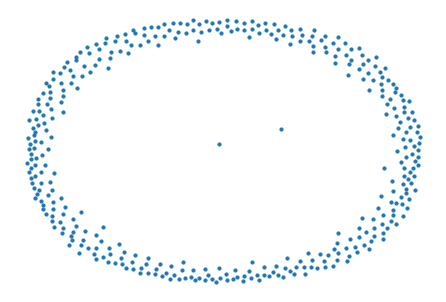

In [12]:
#Build tje network (no links)
path="./files/characters_with_attributes.csv"
attributes = [
    "Name",
    "Race", 
    "Gender",
    "Occupation", 
    "Affiliation", 
    "Age"
]

df = get_df(path, attributes)
G = nx.DiGraph()
for index, row in df.iterrows():
    name,race,gender, occupation, affiliation, age = row
    G.add_node(name, Race=race, Gender=gender, Occupation=occupation, Affiliation=affiliation, Age=age)
#unconnected network
nx.draw(G, node_size=10)

In [73]:
#Extract directed edges and add to the network

#Regex patterns with examples
link_pat1 = r"\[{1,}([^:#\(]*?)(?:\]{1,}|\|)" #[[Gaius van Baelsar]] and [[Ifrit (Final Fantasy XIV)|Ifrit]] (before |)
link_pat2 = r"\[{1,}[^:=]*?\|(.*?)\]{1,}"      #[[Ifrit (Final Fantasy XIV)|Ifrit]] (after |)

#Get the links for each character
for node in G.nodes:
    with open("./files/ff14_chars_json/"+node+".txt", "r", encoding="utf-8") as f:
        node_desc = f.read()
        #Set is used to avoid duplicated edge per character (we don't use weighted edges in this course)
        link1 = set(re.findall(link_pat1, node_desc))
        link2 = set(re.findall(link_pat2, node_desc))
        total_links = link1 | link2 #combine the matches of both regex
        
        for link in total_links:
            if (link in G.nodes) and link != node:#Only add valid links, and discard self-references
                G.add_edge(node, link) #Form the link between the nodes

In [72]:
#Stats before discarding:
print("Number of nodes(Before discarding):", G.number_of_nodes())
print("Number of edges(Before discarding):", G.number_of_edges())

#Discard isolated nodes:
G.remove_nodes_from(list(nx.isolates(G)))

# #Stats after discarding:
print("Number of nodes(After discarding):", G.number_of_nodes())
print("Number of edges(After discarding):", G.number_of_edges()) #edge_before == edges_after --> used to check for errors

Number of nodes(Before discarding): 336
Number of edges(Before discarding): 1484
Number of nodes(After discarding): 336
Number of edges(After discarding): 1484


The total number of links in this directed network is $L = 1484$. In a real network (scale-free), the expectation is that the number of links is much smaller than the theoretical maximum for a directed network, which is described below :

$$L << L_{max}$$

$$L << N(N-1)$$

$$1484 << 385(385-1)$$

$$1484 << 385(385-1)$$

$$1484 << 147840$$

It is worth noting that there were 49 characters with zero connections (isolated nodes), which points towards a real network rather than a random one. For our analysis, the isolated nodes were removed from the network.

In [15]:
# Extracting the GCC
gcc = max(nx.weakly_connected_components(G), key=len)
gcc = G.subgraph(gcc)

print("There are {} nodes in the network.".format(len(gcc.nodes)))
print("There are {} links in the network.".format(len(gcc.edges())))

There are 321 nodes in the network.
There are 1461 links in the network.


In [16]:
#Network stats: most connected characters (in & out)
in_most_connected = sorted(gcc.in_degree,key=lambda x:x[1], reverse=True)[0]
out_most_connected = sorted(gcc.out_degree,key=lambda x:x[1], reverse=True)[0]

print("Most connected character (in-degrees):", in_most_connected)
print("Most connected character (out-degrees):", out_most_connected)

n=5

in_most_connected_ally = sorted(gcc.in_degree,key=lambda x:x[1], reverse=True)[:n]
out_most_connected_ally = sorted(gcc.out_degree,key=lambda x:x[1], reverse=True)[:n]

print(f"Most connected {n} characters (In degree):", in_most_connected_ally, "\n")
print(f"Most connected {n} characters (Out degree):", out_most_connected_ally, "\n")

Most connected character (in-degrees): ('Alphinaud Leveilleur', 57)
Most connected character (out-degrees): ('Alphinaud Leveilleur', 33)
Most connected 5 characters (In degree): [('Alphinaud Leveilleur', 57), ('Gaius van Baelsar', 37), ("Y'shtola Rhul", 35), ('Zenos yae Galvus', 35), ('Thancred Waters', 34)] 

Most connected 5 characters (Out degree): [('Alphinaud Leveilleur', 33), ('Lyse Hext', 30), ("Y'shtola Rhul", 26), ('Elidibus (Final Fantasy XIV)', 26), ('Thancred Waters', 22)] 



In [17]:
df[df.Name =='Alphinaud Leveilleur']

,Name,Race,Gender,Occupation,Affiliation,Age
1,Alphinaud Leveilleur,Elezen,Male,Unknown,Scions of the Seventh Dawn,16


*Alphinaud Leveilleur* is the most connected character both in the in-degree and out-degree sets. He is a significant character in the game. It might be surprising that the main character is not the most connected one, but it is sensible in the context of the dataset: the protagonist of the game is silent. Typically in such plots, a companion character is talkative and well-connected. This is to minimize boredom and break the monotone of silence in the game.

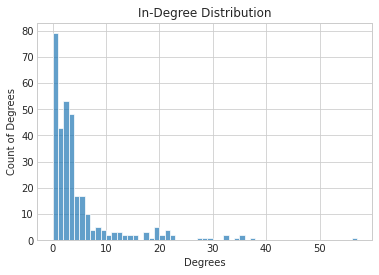

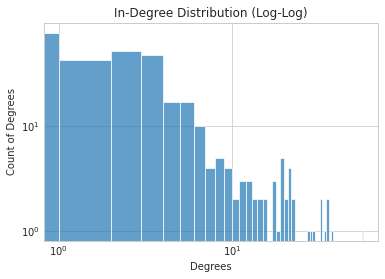

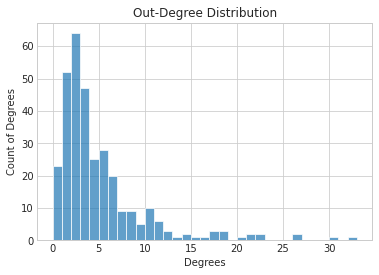

In [18]:
#Plot degree distribution
def plot_degree_dist(g,in_degree=None,scale=None, title="Degree Distribution"):
    if in_degree == True:
        degrees = sorted([d for n, d in g.in_degree()], reverse=True)
    elif in_degree == False:
        degrees = sorted([d for n, d in g.out_degree()], reverse=True)
    elif in_degree == None:
        degrees = sorted([d for n, d in g.degree()], reverse=True)
    plt.hist(degrees, bins=max(degrees), width = 1, edgecolor = "white", alpha =0.7)
    plt.title(title)
    if scale=="log":
        plt.xscale("log")
        plt.yscale("log")
        plt.title(title + " (Log-Log)")
    plt.xlabel("Degrees")
    plt.ylabel("Count of Degrees")
    plt.show()
plot_degree_dist(gcc, in_degree=True, scale=None, title="In-Degree Distribution")
plot_degree_dist(gcc, in_degree=True, scale="log", title="In-Degree Distribution")
plot_degree_dist(gcc, in_degree=False, scale=None, title="Out-Degree Distribution")

Graphically, the in-degree distribution appears to follow a power law distribution, indicating a scale-free network (real network). The out-degree distribution seems to follow a power law distribution, but it is less skewed to the right, and is more difficult to interpret. 

We use the powerlaw function below to fit a power distribution and get the gamma values for further analysis.

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


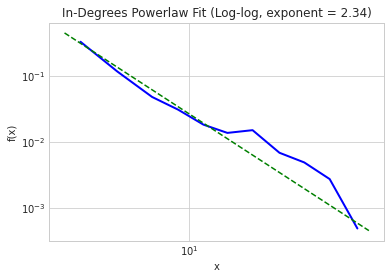

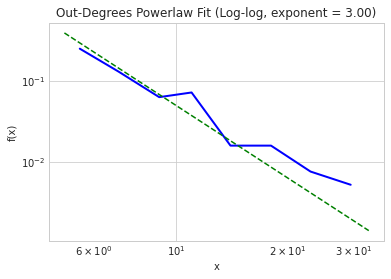

In [19]:
degrees_in =  sorted([d for n, d in gcc.in_degree()], reverse=True)
degrees_out = sorted([d for n, d in gcc.out_degree()], reverse=True)

fit_in  = powerlaw.Fit(degrees_in)
fit_out = powerlaw.Fit(degrees_out)

gamma_in = fit_in.alpha
gamma_out = fit_out.alpha

fig2 = fit_in.plot_pdf(color='b', linewidth=2)
plt.title(f"In-Degrees Powerlaw Fit (Log-log, exponent = {gamma_in:.2f})")
fit_in.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

fig3 = fit_out.plot_pdf(color='b', linewidth=2)
plt.title(f"Out-Degrees Powerlaw Fit (Log-log, exponent = {gamma_out:.2f})")
fit_out.power_law.plot_pdf(color='g', linestyle='--', ax=fig3)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

For the in-degree distribution, the exponent value ($\gamma = 2.33$) indicates that the network is in the scale-free regime (ultra-small world). 
As for the out-degree distribution, the exponent is almost equal to the critical value of 3 ($ \gamma = 3.01$.). While this makes the out-degree distribution more random-like, it is still not the same as a random network, for the value indicate the presence of a double logarithmic correction $lnlnN$ which *shrinks the distances of this network relative to a random network*.

We will compare our network below to a random one of the same probability for further confirmation.

In [70]:
#Change the network from directed to undirected
gcc_undir = nx.DiGraph.to_undirected(gcc)
print(f"Average Degree (undirected): {sum(n for _,n in gcc_undir.degree())/len(gcc_undir)}")
# We set n and k
n = len(gcc_undir.nodes())
k = (2*len(gcc_undir.edges()))/n
p = k/(n-1)

#Create the undirected random network
G_r = nx.gnp_random_graph(n = n, p = p)
print("Number of edges in the undirected network:", len(gcc_undir.edges()))


Average Degree (undirected): 7.102803738317757
Number of edges in the undirected network: 1140


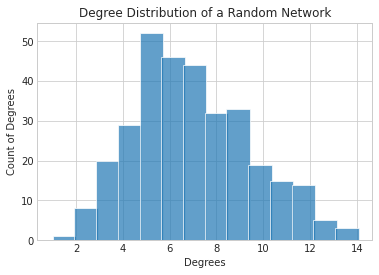

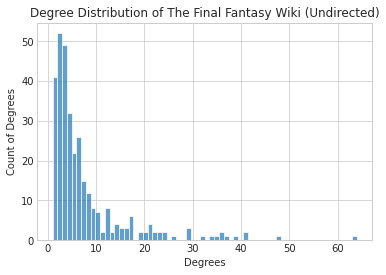

In [71]:
plot_degree_dist(G_r, title="Degree Distribution of a Random Network")
plot_degree_dist(gcc_undir, title="Degree Distribution of The Final Fantasy Wiki (Undirected)")

As seen above, the network's degree distribution significantly deviates from the expected random network. Our graphical, power-law and random network comparison are thus in agreement.

**Goal**: Represent the network graphically and analyze the structure of the created network

**Strategy**:

* Use an undirected network
* ForceAtlas2 algorithm is used to create the network graph
* Scale the node size based on the degree

100%|██████████| 2000/2000 [00:07<00:00, 283.36it/s]
BarnesHut Approximation  took  2.20  seconds
Repulsion forces  took  3.51  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.26  seconds
AdjustSpeedAndApplyForces step  took  0.30  seconds


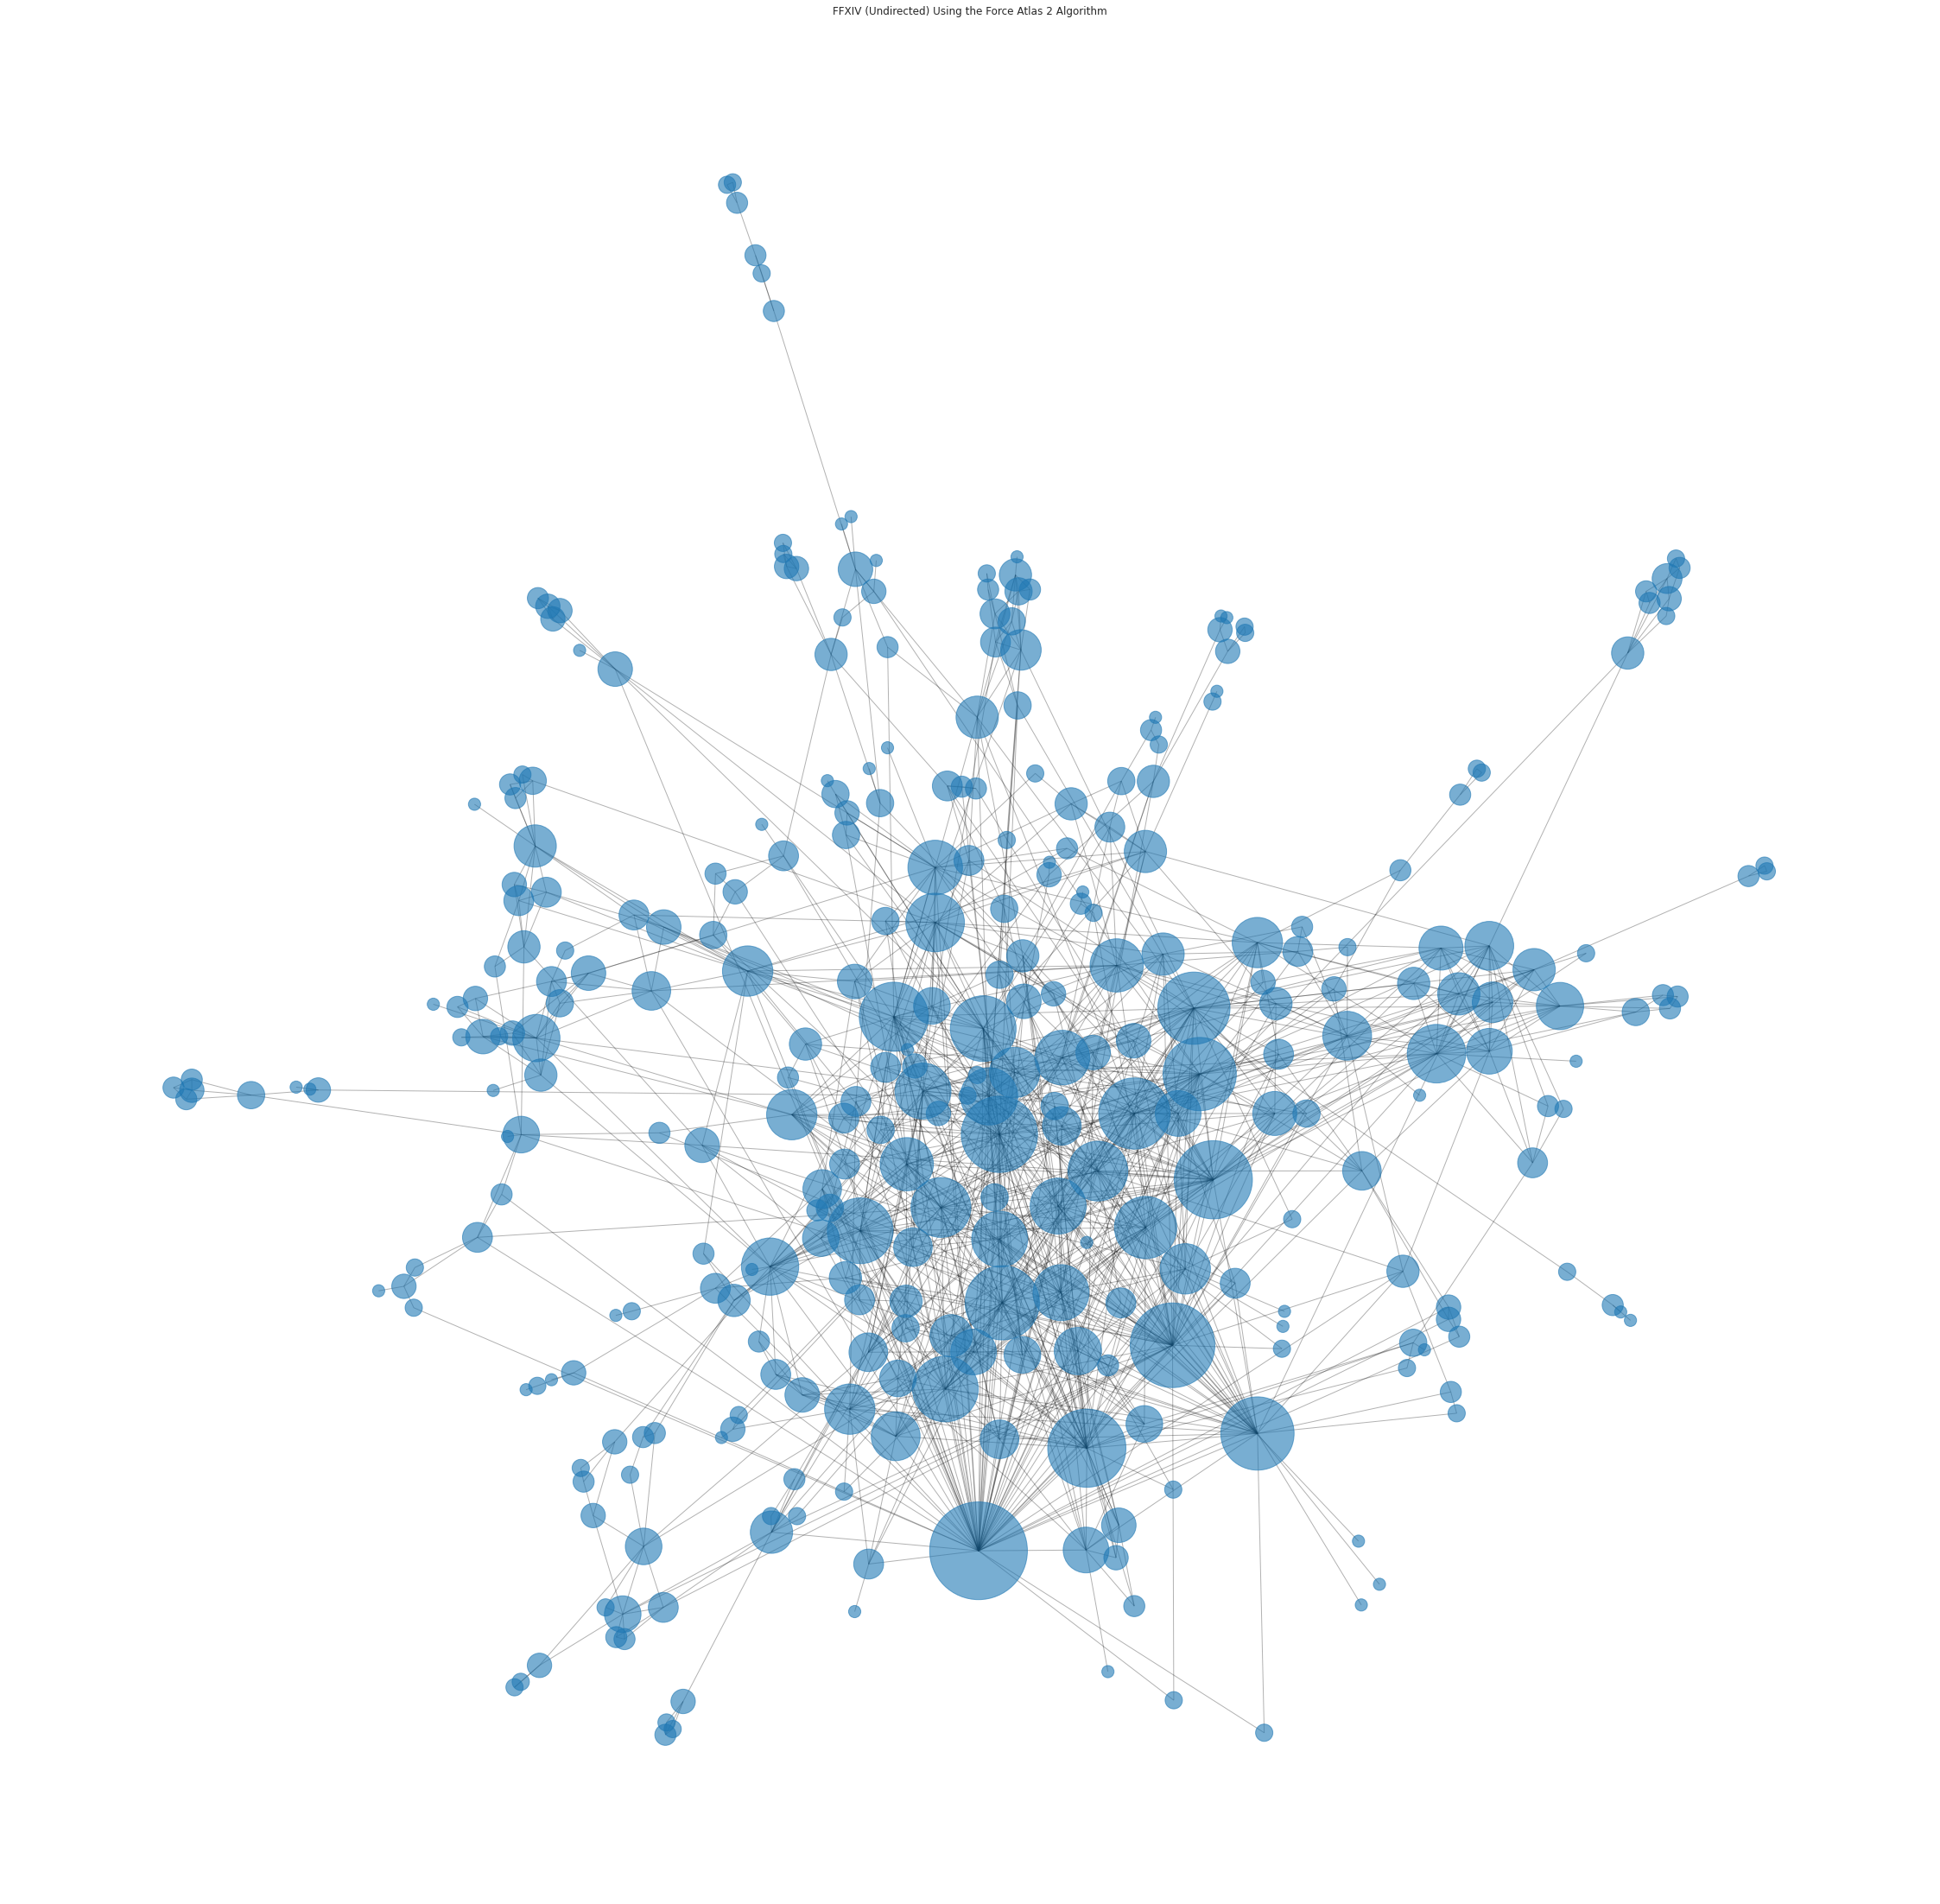

In [22]:
#Graphing the network using ForceAtlas2
#Create the array of sizes based on the degree in G2
size_list = [x[1]*200 for x in list(gcc_undir.degree())]
forceatlas2 = ForceAtlas2(edgeWeightInfluence=2,  scalingRatio=2, outboundAttractionDistribution=True, strongGravityMode=False, gravity=5.0)
positions = forceatlas2.forceatlas2_networkx_layout(gcc_undir, pos=None, iterations=2000)
plt.figure(figsize=(40,40))
nx.draw_networkx_nodes(gcc_undir, positions, node_size=size_list, alpha=0.6)
nx.draw_networkx_edges(gcc_undir, positions, alpha=0.3)
plt.title("FFXIV (Undirected) Using the Force Atlas 2 Algorithm")
plt.axis('off')
plt.show()

While there are significant hubs, the network is not dominated by a single entity ( Link in  Zelda's network). It is expected that in an online RPG, the protagonist is not as critical to the game's plot development relative to single-player games.

### 3.3. Text processing and analyses

**Goal:** Analyze text information from the characters:
* Analyze the most common words in the game
* Plot the wordclouds for each Affiliation

**Strategy:**
* Use Regular expressions to clean the text and elimnate unrelated words.
*  Tokenize the text
* Set everything to lower case
* Exclude punctuation and stop words.
* Exclude characters names (since we're interested in the words, not the names)
* Exclude words related to the videogame, not the characters (since we're interested in the words, not the names)
* Lemmatize your words with WordNetLemmatizer()
* Save the text in a dataframe and as txt file
* Plot the cumulative graph of the most common words in the game

Preprocessing the Final Fantasy text.

In [23]:
path_headers = r'=+[^=].*=+.*'  # Clean headers
path_para = r'\(.*?\)'    # Clean other characters names
link_pat1 = r'\(\w+\)'
link_pat2 = r'\[\w+\]'
link_pat3 = r'\{\w+\}'

The following code import the csv with the characters and they attributes and create a new dataframe (and csv) containing the threated text descriptions of every character. 

In [24]:
#Read the file containing the character's page description.
df_clean = pd.read_csv('./files/characters_with_attributes.csv')
df_characters = df_clean['Name']
character_list = df_characters.values
path = './files/ff14_chars_json/'
output_path = './files/ff14_chars_txt_lemmatize/'
txt_list = []
# Create a new column Txt to contain the processed text from each character
# df_clean['Txt'] = ""
all_files = os.listdir(path)
videogame_related_words = ['sideicon','infobox','prime','ffxiv','fftcg','displaytitle','xiv','png','jpg','ffiv']
for char in df_characters:
    with open(path+char+'.txt', 'r', encoding='utf-8') as fd:
        lines = fd.readlines()
        lines_cln = "".join(lines)
        lines_cln = re.sub(link_pat1, "", lines_cln)
        lines_cln = re.sub(link_pat2, "", lines_cln)
        lines_cln = re.sub(link_pat3, "", lines_cln)

        lines_cln = re.sub(path_headers, "", lines_cln) # it is possible to further clean the text
        
        #Tokenize your text with WordPunctTokenizer()
        tokens = WordPunctTokenizer().tokenize(lines_cln)
        #Set everything to lower case.
        tokens = [word.lower() for word in tokens]
        # Exclude punctuation and stop words.
        tokens = [word for word in tokens if word not in set(stopwords.words("english"))]
        tokens = [word for word in tokens if word.isalnum()]
        #Exclude characters names (since we're interested in the words, not the names)
        tokens = [word for word in tokens if word not in character_list]
        #Exclude words related to the videogame, not the characters (since we're interested in the words, not the names)
        tokens = [word for word in tokens if word not in videogame_related_words]
        #Lemmatize your words with WordNetLemmatizer()
        wnl = nltk.WordNetLemmatizer()
        tokens = [wnl.lemmatize(word) for word in tokens]
        # Save plain text in df_clean
        tokens_txt = " ".join(tokens)
        #df_clean.loc[df_clean['Name'] == char, ['Txt']] = tokens_txt
        txt_list.append(tokens_txt)
        # Save plain text in txt file
        with open(output_path+char+".txt", "w", encoding="utf-8") as fo:
            fo.write(tokens_txt)
df_clean['Txt'] = txt_list
df_clean.to_csv('./files/characters_with_attributes_txt.csv')

**Comments**
- Now df_clean contains the lemmatized text in the column 'Txt'. 
- The file folder contains the ff14_txt_lemmatized folder with all .txt files with the lemmatized texts. 
- The csv file 'characters_with_attributes_txt.csv' contains all the information gathered up to this moment.
- Further information related to the videogame and not the character has been eliminated ('sidecon', 'ffiv' for example).

In [25]:
df_clean = pd.read_csv('./files/characters_with_attributes_txt.csv')
df_clean[272:280]

,Unnamed: 0,Unnamed: 0.1,Name,Race,Gender,Occupation,Affiliation,Age,Txt
272,272,272,"Almet, Cymet, and Uimet",Viera,Female,Unknown,Unknown,Unknown,character name almet cymet uimet release japan...
273,273,273,Ciuna and Phyna,Viera,Female,Unknown,Fanow,Unknown,character name ciuna phyna release japanese シュ...
274,274,274,Quinfort,Au Ra,Male,Unknown,Night's Blessed,Unknown,character name quinfort release japanese キンフォー...
275,275,275,Valan,Hyur,Male,Unknown,Night's Blessed,Unknown,character name valan release japanese ヴァラン rom...
276,276,276,Xande (Final Fantasy XIV),Unknown,Male,Emperor,Allagan Empire,Unknown,xande final fantasy character name xande relea...
277,277,277,Doga (Final Fantasy XIV),Hyur,Male,Unknown,Allagan Empire,Unknown,doga final fantasy character name doga release...
278,278,278,Unei (Final Fantasy XIV),Hyur,Female,Unknown,Allagan Empire,Unknown,unei final fantasy character name unei release...
279,279,279,Amon (Final Fantasy XIV),Unknown,Male,Unknown,Allagan Empire,Unknown,amon final fantasy character name amon release...


In [26]:
path_lemmatized = './files/ff14_chars_txt_lemmatize/'
# Use the funciton PlaintextCorpusReader from nltk.corpus to create the FFIXwiki corpus 
ffiv_wiki = PlaintextCorpusReader(path_lemmatized, ".*", encoding="utf-8")

#Preserve order by passing the list of chars
txts = nltk.Text(ffiv_wiki.words(list(character_list+".txt")))

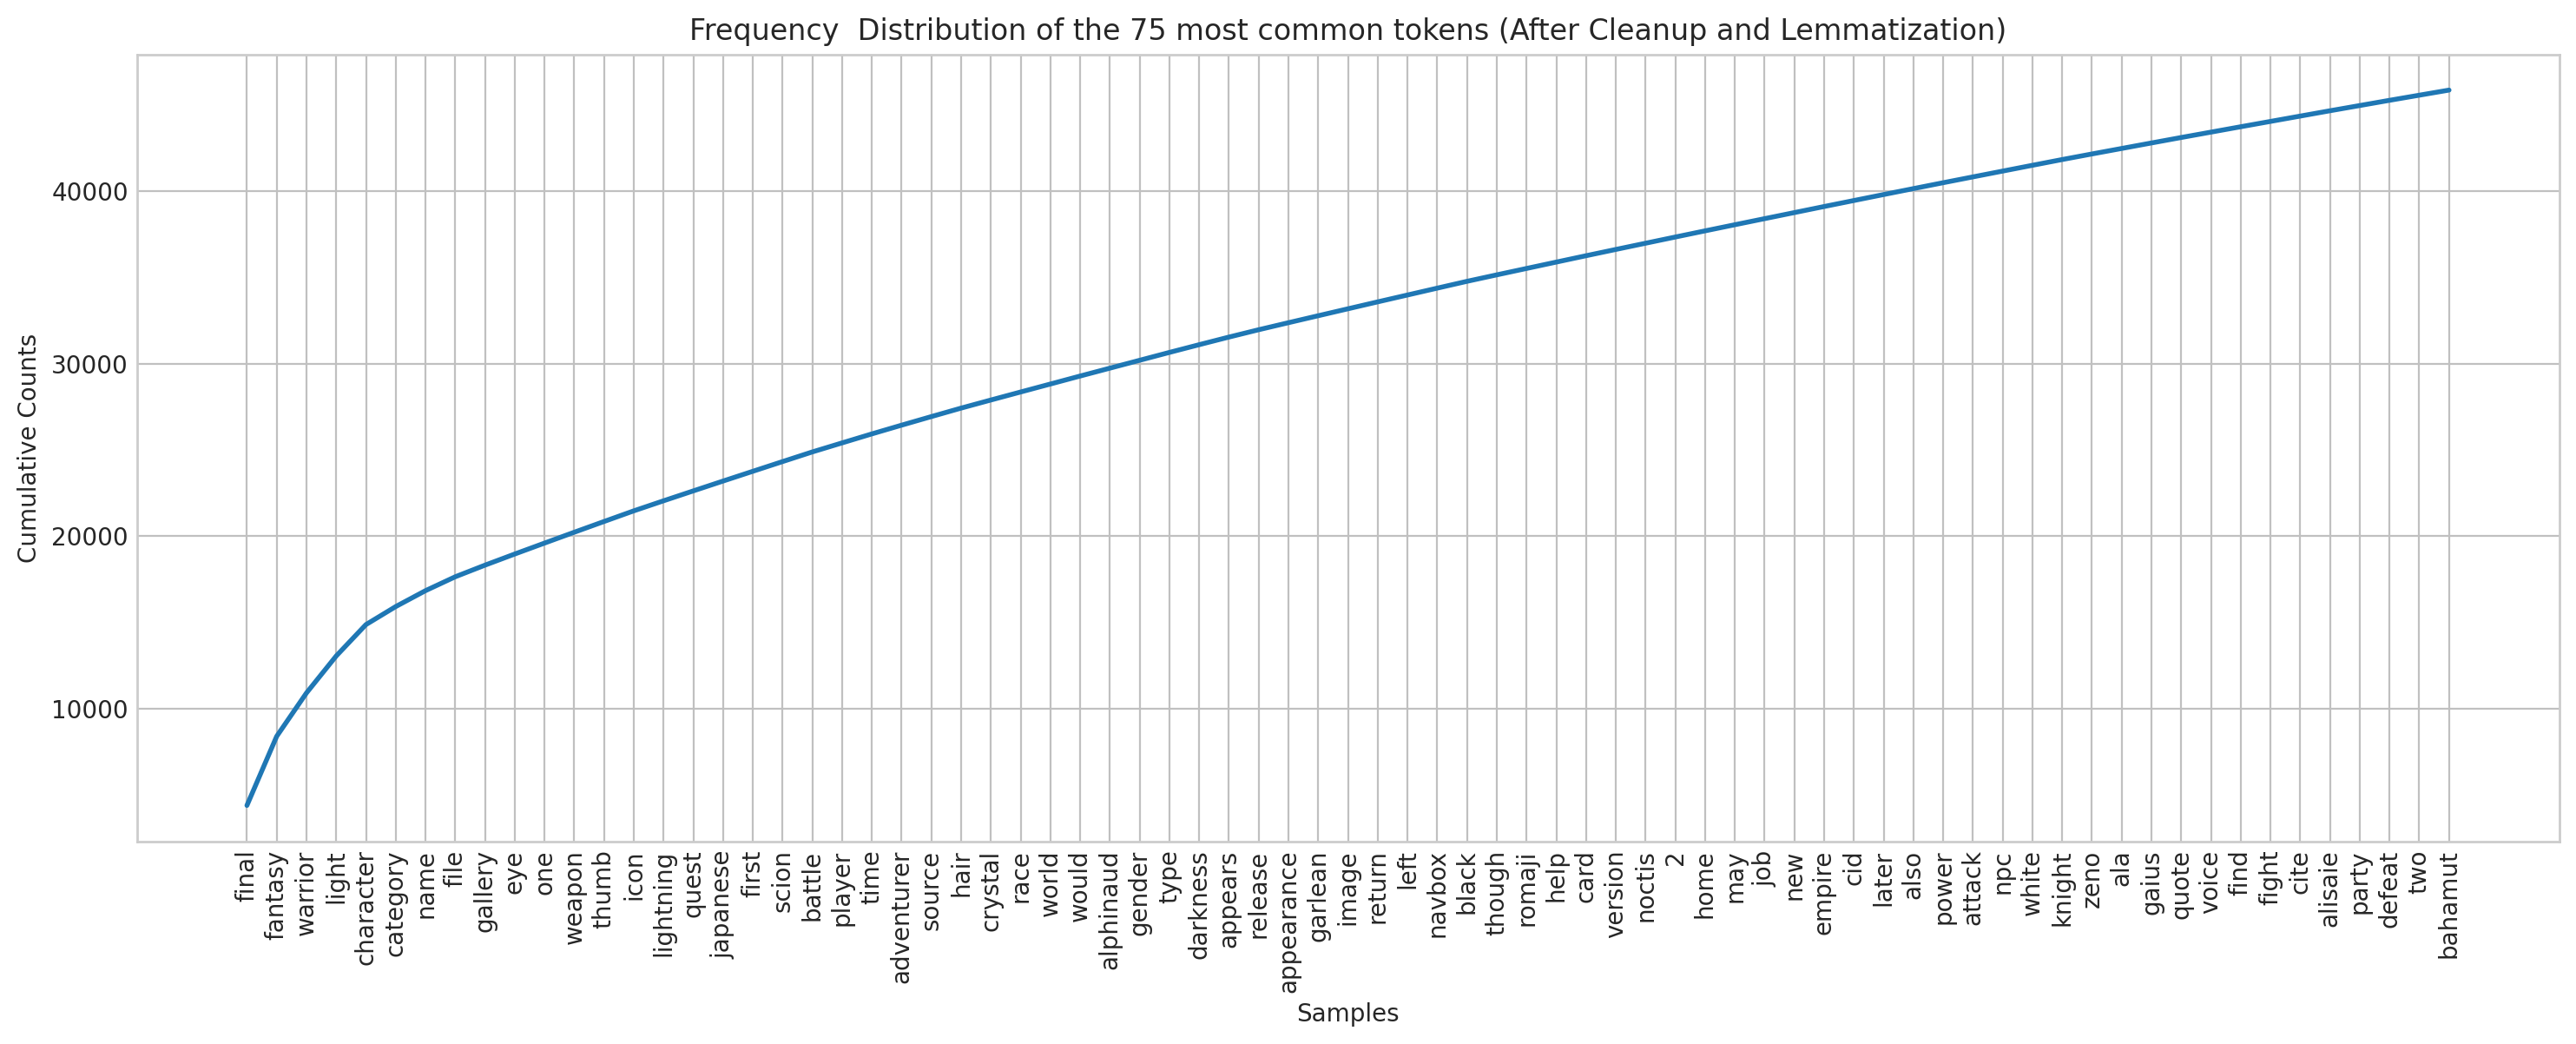

<AxesSubplot:title={'center':'Frequency  Distribution of the 75 most common tokens (After Cleanup and Lemmatization)'}, xlabel='Samples', ylabel='Cumulative Counts'>

In [27]:
fig = plt.figure(figsize=(18,6), dpi=200)
plt.title("Frequency  Distribution of the 75 most common tokens (After Cleanup and Lemmatization)")
freq_txts = nltk.FreqDist(txts)
freq_txts.plot(75, cumulative=True)

The frequency plot of the most common words is as expected: the two most common words are "final" and "fantasy," followed by "warrior" and "light." It is worth mentioning that the main character of the game is named "The Warrior of Light." Therefore, the high frequency of these two words is unsurprising.

### 3.4. Word Cloud

Word clouds are a visual representation of text data, typically used to depict keyword metadata (tags) on websites, or to visualize free form text. In this case, the tags are single words, and the importance of each tag is shown with font size: bigger term means greater weight.

**Goal**: Analyze the word cloud for some groups of characters

**Strategy**: 
* Obtain the 3 greatest Affiliations, and the characters who belong to them.
* Calculate the TF and TF-IDF values for each affiliation
* Analyze the wordcloud over the text previously obtained.

In [28]:
#Load text for each affiliation into a dictionary {"affiliation" :"full_cleaned_text"}

affiliation_dic = {}
for char in df_clean.Name:
    affiliation = df_clean.loc[df_clean["Name"] == char, "Affiliation"].values[0] #Get the affiliation of the char
    if affiliation in affiliation_dic: #If race exists in the dictionary, append the text
        affiliation_dic[affiliation] += " " + str(df_clean.loc[df_clean["Name"] == char, "Txt"].values[0])
    else: #Otherwise, make a new entry with the text for this affiliation
        affiliation_dic[affiliation] = df_clean.loc[df_clean["Name"] == char, "Txt"].values[0]

Get TF values for each word

In [29]:
counts_dic = {} #TC values
tf_dic = {} #Normalized TC values (TF)
affiliations = df_clean.Affiliation.unique()

for affiliation in affiliations:
    counts = Counter(affiliation_dic[affiliation].split()) #Count the occurance of each word per race to get TC
    counts_dic[affiliation] = counts
    tfs = [(k,v/len(affiliation_dic[affiliation].split())) for k,v in counts.items()] #divide by total number of words per race to get TF
    tf_dic[affiliation] = tfs

Calculate IDF

In [30]:
N = len(affiliation)
df = {}

#Get all words from the text, irrespective of race
all_words_list = (list(affiliation_dic.values()))
all_words = set((' '.join(all_words_list)).split()) #Remove duplicated words

#Calculate DF first: Check if a word exists in each "document"
for word in all_words:
    for affiliation in affiliations:
        if word in affiliation_dic[affiliation]:
            if word in df:
                df[word]+=1 #max value = number of affiliations = 27
            else:
                df[word]=1

idf = {k:math.log(N/(v+1)) for k,v in df.items()}
idf = dict(sorted(idf.items(), key=lambda item:item[1],reverse=True))

Calculate the most important affiliations:

In [31]:
Affiliations = {}
Affiliations_keys = set(df_clean['Affiliation'])
for affiliation in Affiliations_keys:
    count = len(df_clean['Affiliation'][df_clean['Affiliation']==affiliation])
    Affiliations[affiliation] = count
del Affiliations['Unknown']
greatest_affiliations = heapq.nlargest(3, Affiliations, key=Affiliations.get)
print('The greatest Affiliations are:\n')
for affiliation in greatest_affiliations:
    print(affiliation, Affiliations[affiliation])

The greatest Affiliations are:

Garlean Empire 16
High Houses of Ishgard 10
Doma 9


Calculate the tc_idf

In [32]:
#For WordCloud, we need tc_idf
tc_idf = {}
for affiliation in affiliations:
    rslt = []
    for word,counts in counts_dic[affiliation].items():
        tc_idf_word = int(round(counts*idf[word],0)) #Repeat the word by its count
        if tc_idf_word >=0:
            for i in range(tc_idf_word):
                rslt.append(word) #Add the word to a list "count" times
    tc_idf[affiliation]=" ".join(rslt) #Convert to str for the wordcloud library

Wordcloud of the three most important affiliations:

In [34]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

<Figure size 432x288 with 0 Axes>

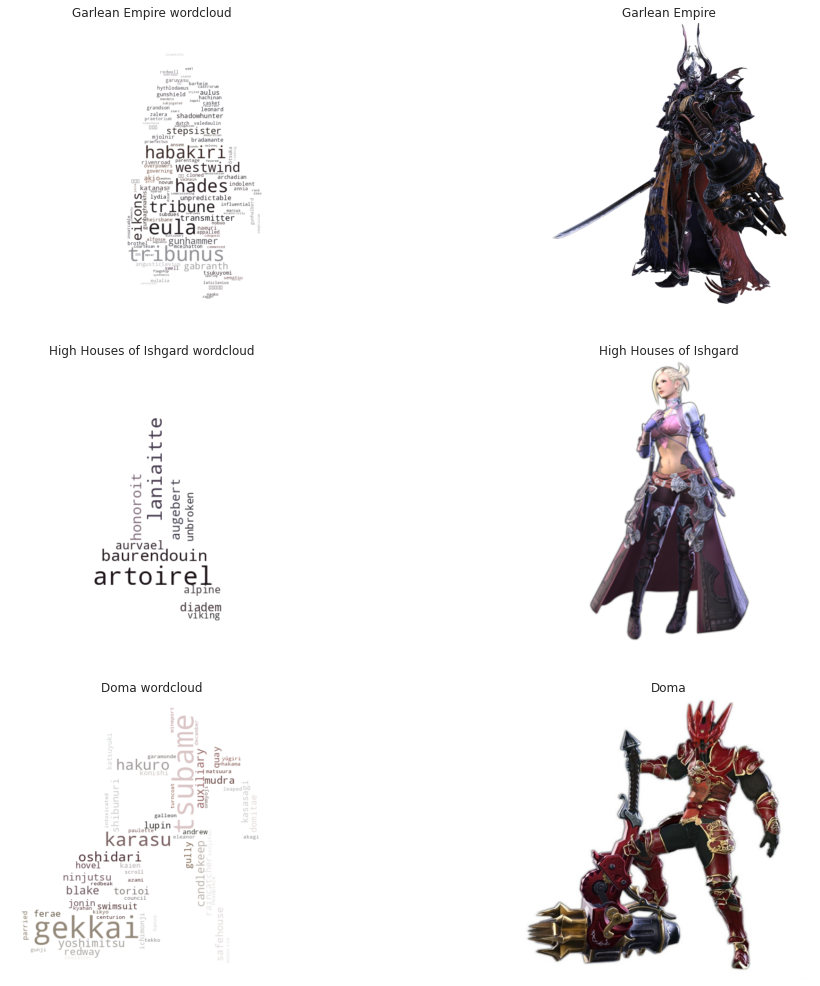

In [36]:
heros = ['Garlean Empire', 'High Houses of Ishgard', 'Doma']
plt.figure()
stopwords = set(STOPWORDS)
plt.figure(figsize=[17, 30])

for t in range(len(heros)):
    plt.subplot(5, 2, 2*t+1).set_title(heros[t]+" wordcloud")
    
    mask = np.array(Image.open(heros[t]+".png"))
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1],mask.shape[2]), np.int32)
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            transformed_mask[i][j] = list(map(transform_format, mask[i][j]))
            
    image_colors = ImageColorGenerator(mask)
    
    wordcloud = WordCloud(max_font_size=130, collocations = False, width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords,
                mask = transformed_mask,
                min_font_size = 10).generate(tc_idf[heros[t]])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.subplot(5, 2, 2*t+2).set_title(heros[t])
    plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
plt.show()

### 3.5. Community Detection and Analysis

In this section we are interested in analyzing the relations amongst the characters. In particular, we want to try to detect communities and study their characteristics. In order to perform this analysis, we are going to apply the Louvain Algorithm for community detection to the undirected network created in the previous sections.

**Goal**: Detect and analyze communities in the network

**Strategy**:
* Apply the Louvain Algorithm to the network
* Apply the TF and TF-IDF algorithm to the text of the characters in each community
* Perform sentiment analysis over the characters 

In [37]:
partition = community_louvain.best_partition(gcc_undir)
print("We found", len(set(partition.values())), "communities")

We found 14 communities


In [38]:
print("The modularity of the partition is" ,community_louvain.modularity(partition, gcc_undir))

The modularity of the partition is 0.4931875192366882


The modularity value is approximately 0.5, representing a good communities partition.

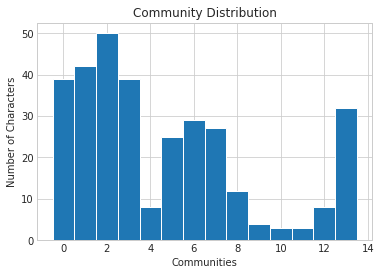

In [39]:
plt.hist(partition.values(), bins=np.arange(-0.5,len(set(partition.values())), 1), histtype='bar', edgecolor='white')
plt.xlabel("Communities")
plt.ylabel("Number of Characters")
plt.title("Community Distribution")
plt.show()

The algorithm detects 6 small communities that have less than 10 characters, and 8 bigger communities that have between 20 and 50 characters. In the following plot the network is represented with a different color for every community.

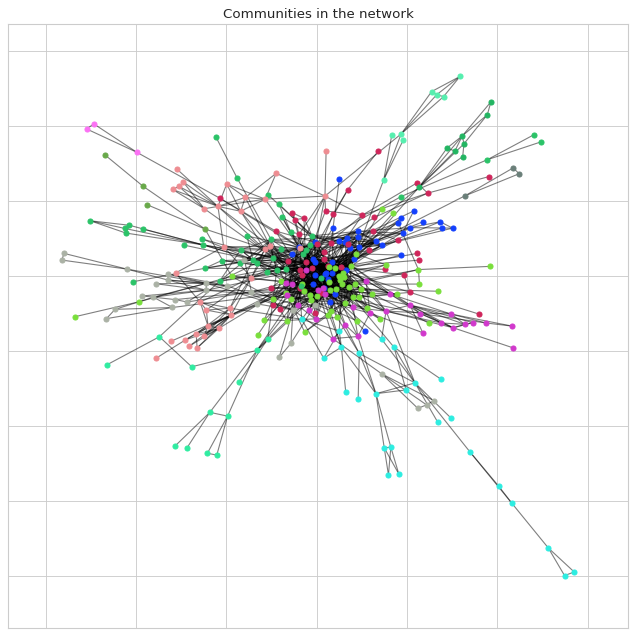

In [40]:
# Drawing the communities
size = float(len(set(partition.values())))
pos = nx.spring_layout(gcc_undir)
count = 0.
plt.figure(figsize=(10, 10), dpi=80)
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(gcc_undir, pos, list_nodes, node_size = 20, node_color = "#"+''.join(random.choice('0123456789ABCDEF') for j in range(6)))
nx.draw_networkx_edges(gcc_undir, pos, alpha=0.5)
plt.title('Communities in the network')
plt.show()

The characters belonging to the 5 most populous communities have been reported in the following section.

In [41]:
#Calculate the communities

communities = {}
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    communities[com] = list_nodes
index_list_max = heapq.nlargest(5, communities, key=lambda x:len(communities[x])) # get indexes of 5 largest communities

print("Below, the 5 greatest communitites are represented.\n")

for i in index_list_max:
    print("---> Community ", i)
    print(communities[i]) # -> access the nodes of the 5 biggest communities, TF-IDF can now be applied to each one of them
    print()

Below, the 5 greatest communitites are represented.

---> Community  2
['Lyse Hext', 'Papalymo Totolymo', 'Yda Hext', 'Arenvald Lentinus', 'Riol Forrest', 'Alianne Vellegrance', 'Elidibus (Final Fantasy XIV)', 'Fandaniel', 'Varis zos Galvus', 'Zenos yae Galvus', 'Asahi sas Brutus', 'Aulus mal Asina', 'Fordola rem Lupis', 'Grynewaht pyr Arvina', 'Maxima quo Priscus', 'Dewlala Dewla', 'Erik', 'Hamon Holyfist', 'Lolorito Nanarito', 'Pipin Tarupin', 'Teledji Adeledji', 'Yuyuhase Luluhase', 'Conrad Kemp', 'Curtis Hext', 'Gundobald', 'Ilberd Feare', "M'naago Rahz", 'Meffrid Noward', 'The Griffin', 'Widargelt Beake', 'Hien Rijin', 'Yugiri Mistwalker', 'Gosetsu Daito', 'Yotsuyu goe Brutus', 'Hakuro Gunji', 'Kurobana', 'Tenzen (Final Fantasy XIV)', 'Hancock Fitzgerald', 'Kotokaze Benitoki', 'Kurenai Shisui', 'Cirina Mol', 'Magnai Oronir', 'Sadu Dotharl', 'Xande (Final Fantasy XIV)', 'Odin (Final Fantasy XIV)', 'Shinryu (Final Fantasy XIV)', 'Tsukuyomi (Final Fantasy XIV)', 'Edda Pureheart', 'Un

**Results**

The Louvain Algorithm can detect 14 communities in the network and the modularity has a value of 0.5. Since it is not zero or negative, we consider this to be a good theoretical partition. Characters belonging to the same community, are expected to be more connected to each other in the game compared to character belonging to different communities. To prove this point more accurately, it would be necessary to analyze the game more in deep and gather information regarding the actual story behind each character and their true relations with each other in the game. We will not continue this analysis. Instead, we are going to analyze which words are the most representative of each community and finally, we will study the average sentiment of these communities, to understand if there is a common positive or negative feeling among the character of a group.

### 3.6. Common words in the communities

In this section we are going to identify the most descriptive words related to each community. The objective is to understand if different communities have different related words. We are going to use two different methods: the TF and and the TF-IDF. The first one will take into account how much a specific word appear in the text, while the other will also consider how often that word appear through the whole database, adding value to those words that are more characteristic of a specific community, therefore more relevant. 

To perform the following analyses, we will load the text corresponding to each community into a dictionary: 

{"community_name" :"full_cleaned_text"}.

Each community will be identified by the name of the first character in the community: 

e.i. Community 1 -> 'Alphinaud Leveilleur'.

In [43]:
community_dic = {}
for community in communities.values():
    name_of_community = community[0]
    for char in community:
        if name_of_community in community_dic:  #If community exists in the dictionary, append the text
            community_dic[name_of_community+'\'s community'] += " " + df_clean.loc[df_clean["Name"] == char, "Txt"].values[0]
        else: #Otherwise, make a new entry with the text for this community
            community_dic[name_of_community+'\'s community'] = df_clean.loc[df_clean["Name"] == char, "Txt"].values[0]

Calculate the TF values for each word.

In [44]:
counts_dic = {} #TC values
tf_dic = {} #Normalized TC values (TF)
community_list = list(community_dic.keys())

for community in community_list:
    counts = Counter(community_dic[community].split()) #Count the occurance of each word per race to get TC
    counts_dic[community] = counts
    tfs = [(k,v/len(community_dic[community].split())) for k,v in counts.items()] #divide by total number of words per race to get TF
    tf_dic[community] = tfs

Calculate the most common words using TF for the top 5 communities.

In [45]:
tf_dic = {}
counts_dic = {}
top = 5

for community in [community_list[x] for x in index_list_max]:
    counts = Counter(community_dic[community].split())
    counts_dic[community] = counts
    print('---> Community: ', community)
    print(counts.most_common(top)) #print the most common words/race
    tfs = [(k,v/len(community_dic[community].split())) for k,v in counts.items()] #divide by total words/race to get tf
    tf_dic[community] = tfs
    print()

---> Community:  Lyse Hext's community
[('nybeth', 15), ('dead', 8), ('final', 6), ('palace', 6), ('warrior', 6)]

---> Community:  Alphinaud Leveilleur's community
[('darkness', 49), ('cloud', 40), ('final', 29), ('fantasy', 26), ('world', 10)]

---> Community:  Warrior of Light (Final Fantasy XIV)'s community
[('yoshida', 42), ('naoki', 34), ('final', 22), ('fantasy', 22), ('april', 16)]

---> Community:  Estinien Wyrmblood's community
[('garuda', 27), ('final', 21), ('fantasy', 20), ('messenger', 18), ('xv', 14)]

---> Community:  H'naanza Esi's community
[('marcelloix', 13), ('character', 5), ('final', 4), ('fantasy', 4), ('ehll', 4)]



Calculate the most common words using TF-IDF for the top 5 communities.

In [46]:
N = len(index_list_max)
df = {}
all_words_list = (list(community_dic.values()))
all_words = set((' '.join(all_words_list)).split()) #look-up only unique words in the corpus

for word in all_words:
    for community in [community_list[x] for x in index_list_max]:
        if word in community_dic[community]:
            if word in df:
                df[word]+=1
            else:
                df[word]=1

idf = {k:math.log(N/(v+1)) for k,v in df.items()}
idf = dict(sorted(idf.items(), key=lambda item:item[1],reverse=True))
tf_idf = {}

for community in [community_list[x] for x in index_list_max]:
    rslt = []
    for word,tf in tf_dic[community]:
        rslt.append((word,tf*idf[word]))
    rslt.sort(key=lambda x:x[1],reverse=True)
    tf_idf[community] = rslt
    

#Highest 5 tf-idf values for each community
for community in tf_idf:
    print("---> Community: ", community)
    print(tf_idf[community][:top])
    print()

---> Community:  Lyse Hext's community
[('nybeth', 0.04755834248481774), ('dead', 0.025364449325236127), ('palace', 0.019023336993927095), ('necromancer', 0.012682224662618063), ('edda', 0.012682224662618063)]

---> Community:  Alphinaud Leveilleur's community
[('darkness', 0.07300527782411968), ('cloud', 0.05959614516254668), ('eden', 0.011919229032509335), ('xande', 0.010429325403445669), ('doga', 0.008939421774382)]

---> Community:  Warrior of Light (Final Fantasy XIV)'s community
[('yoshida', 0.08000875413454162), ('naoki', 0.06476899144224797), ('april', 0.030479525384587283), ('fool', 0.030479525384587283), ('director', 0.01904970336536705)]

---> Community:  Estinien Wyrmblood's community
[('garuda', 0.03616937099503244), ('messenger', 0.02411291399668829), ('wind', 0.010716850665194797), ('xv', 0.01045549522328051), ('statue', 0.009377244332045447)]

---> Community:  H'naanza Esi's community
[('marcelloix', 0.07219260311735767), ('ehll', 0.02221310865149467), ('francel', 0.022

**Results:**
It appear clear how the TF-IDF analysis gives more interesting results in identifying the most relevant words of a community, by eliminating recurring words as 'fantasy', 'player' and 'final' that are clearly related to the game itself, and thus very common in all the communities. We can also see from the results that the second method does not ever return the same word for different communities, as it happen in the TF analysis, confirming that the TF-IDF is more accurate in detecting the relevant words in a community.

### 3.7. Sentiment Analysis

We now proceed performing a sentiment analysis of the communities, after we gather the adequate text information related to the story of the characters. 

We are going to perform different analyses. Firstly, we are going to use the LabMT dataset, to calculate the sentiment of each token, created from the textual description of the characters obtained from the wikipages, after proper tokenization and lemmatization. Subsequently, we are going to repeat the same process, this time using the text obtained from written dialogues extracted from the game. This second analysis is expected to return a better understanding of the sentiment of the characters, since it will contain more textual information related to the feelings and sentiments of the characters during the game. 

Lastly, we will use the VADER sentiment analysis tool, applied on the dialogues text. This method will also take into account different aspects of the speeches, like the use of punctuation, capital letters and specific expressions.

**Goal**: Perform sentiment analysis over the community

**Strategy**: 
* Collect and preprocess dialogues from the game
* Try both LabMT and VADER analyses on the text data collected from the wiki pages and on the dialogues 

Importing the LabMT database.

In [47]:
import pandas as pd
df = pd.read_csv('./files/Data_Set_S1.txt', delimiter = "\t")
df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [48]:
def sentiment_calculator_LabMT(tokens):
    sumy=0
    length=0
    for token in tokens:
        if token in df['word'].values:
            sumy = sumy + float(df.happiness_average[df.word==token])
            length = length + 1
    return sumy/length

Calculate the sentiment of each community and fill a dictionary with the results: 

i.e.: sentiment_community_dict = {Community: sentiment_value}

#### 3.7.1. Sentiment Analysis 1

Data: Text description from the Wikipages

Method: LabMT

In [63]:
sentiment_community_dict = {}
lemmatizer = WordNetLemmatizer()
for i in index_list_max:
    sumy = 0 
    length = 0
    for char in communities[i]:
        tokenized_sentence = lemmatizer.lemmatize(str(df_clean.Txt[df_clean['Name']==char]))  #lemmatize the sentence
        tokenized_sentence = word_tokenize(tokenized_sentence)  # tokenize the sentence
        tokenized_sentence = [token.lower() for token in tokenized_sentence] # set to lower case the sentence
        sumy += sentiment_calculator_LabMT(tokenized_sentence)
        length += 1 #calculate average of the sentences of this character
    sentiment_community_dict[communities[i][0]] = sumy/length

In [64]:
print('Average sentiment of the 5 greatest communities:')
sentiment_community_dict

Average sentiment of the 5 greatest communities:


{'Lyse Hext': 5.687844285714285,
 'Alphinaud Leveilleur': 5.679974489795918,
 'Warrior of Light (Final Fantasy XIV)': 5.685343711843711,
 'Estinien Wyrmblood': 5.666772283272282,
 "H'naanza Esi": 5.615598214285714}

The distribution of the sentiment through the 5 greatest communities is shown below.

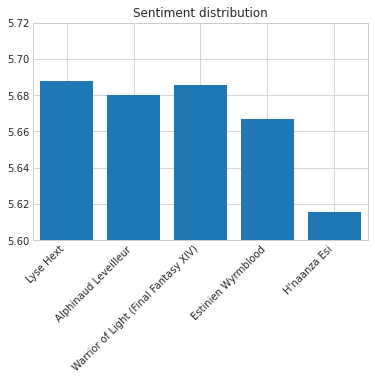

In [65]:
plt.bar(sentiment_community_dict.keys(), sentiment_community_dict.values())
plt.xticks(rotation=45, ha="right")
plt.axis([-0.5, 4.5, 5.60, 5.72])
plt.title('Sentiment distribution')
plt.show()

All values are just above 5, showing that there is a slight positive sentiment, althogh since the text used for this analysis was collected from the descriptions of the characters, the information they carry about feelings and sentiments of the characters is quite poor, hence the result is expected. We now repeat the analysis with a more relevant database: written dialogues from the videogame.

#### 3.7.2. Sentiment Analysis 2

Data: Dialogues from the Videogame

Method: LabMT

In [52]:
filename = './files/Dialogue Collection.txt'
  
# dictionary where the lines from the text will be stored
dict1 = {}

# creating dictionary
with open(filename, encoding="UTF-8") as f:
    lines = (line.rstrip() for line in f) # All lines including the blank ones
    lines = (line for line in lines if line) # Non-blank lines

    for line in lines:
        if ':' in line:
#             print(line)
            # reads each line and trims of extra the spaces 
            # and gives only the valid words
            command, description = line.strip().split(':', 1) # split the line at the :
            if command in dict1.keys():
                dict1[command] += "".join(description)   # fill the dict1 -> {char: Dialogue}
            else: 
                dict1[command] = description

The file containing the character's dialogues only has first names, not surnames or complete names. Also, not all characters are in the dialogues. To solve the problem of the uncompleted names, the dictionary keys are replaced with the full name of the character (when it is possible to identify the character).

In [53]:
names = df_clean['Name'].values
keys = list(dict1.keys())
for name in names:
    for key in keys:
        if key == name.split()[0]:
            dict1[name] = dict1[key]

The following list contains the characters who were identified in the dialogues.

In [54]:
list(x for x in dict1.keys() if x in names)

['Janremi Blackheart',
 'Eline Roaille',
 'Mutamix Bubblypots',
 "F'hobhas",
 'Lahabrea',
 'Frixio',
 'Gundobald',
 "R'ashaht Rhiki",
 'Brayflox Alltalks',
 'Iliud',
 'Forlemort',
 'Gaius van Baelsar',
 'Pashtarot',
 'Igeyorhm',
 'Nabriales',
 'Alphinaud Leveilleur',
 'Alisaie Leveilleur',
 "Y'shtola Rhul",
 'Thancred Waters',
 'Urianger Augurelt',
 'Minfilia Warde',
 'Papalymo Totolymo',
 'Yda Hext',
 'Tataru Taru',
 'Arenvald Lentinus',
 'Riol Forrest',
 'Cid Garlond',
 'Biggs and Wedge (Final Fantasy XIV)',
 'Buscarron Stacks',
 'Momodi Modi',
 'Serendipity (Final Fantasy XIV)',
 'Baderon Tenfingers',
 "H'naanza Esi",
 'Haurchefant Greystone',
 'Drillemont de Lasserrant',
 'Meffrid Noward',
 'Ifrit (Final Fantasy XIV)',
 'Titan (Final Fantasy XIV)',
 'Garuda (Final Fantasy XIV)',
 'Edda Pureheart',
 'Garuda (Final Fantasy XV boss)',
 'Garuda (Final Fantasy XV summon)']

The dialogues do not contain all the characters from the game, even though we checked that each community must have at least several characters found in the dialogues. For this reason the sentiment analysis using this dataset will be an approximation of the real sentiment. It would be necessary to gather more dialogues from the game to get a more accurate result. For the scope of this project, we will continue anyway using this dialogues, analyzing the sentiment of each characters and then calculate the average sentiment of the communities.

In [55]:
def sentiment_calculator_LabMT(tokens):
    sumy=0
    length=0
    for token in tokens:
        if token in df['word'].values:
            sumy += float(df.happiness_average[df.word==token])
            length += 1
    return sumy/length

In [56]:
sentiment_community_dict = {}
sentiment_community_all = {}
lemmatizer = WordNetLemmatizer()
for i in index_list_max:
    sumy = 0 
    length = 0
    for char in communities[i]:
        if char in list(dict1.keys()):
            # print('Community:',communities[i][0], '---> Character dialogue found:', char)
            #Tokenize your text with WordPunctTokenizer()
            tokens = WordPunctTokenizer().tokenize(dict1[char])
            # Exclude punctuation and stop words.
            tokens = [word for word in tokens if word.isalnum()]
            #Set everything to lower case.
            tokens = [word.lower() for word in tokens]
            #Lemmatize your words with WordNetLemmatizer()
            wnl = nltk.WordNetLemmatizer()
            tokens = [wnl.lemmatize(word) for word in tokens]
            tmp_value = sentiment_calculator_LabMT(tokens)
            sumy += tmp_value
            length += 1 #calculate average of the sentences of this character
            if communities[i][0] in list(sentiment_community_all.keys()):
                sentiment_community_all[communities[i][0]].append(tmp_value)
            else:
                sentiment_community_all[communities[i][0]] = [] 
                sentiment_community_all[communities[i][0]].append(tmp_value)
    sentiment_community_dict[communities[i][0]] = sumy/length

In [57]:
print('Average sentiment of the 5 greatest communities:')
sentiment_community_dict

Average sentiment of the 5 greatest communities:


{'Lyse Hext': 5.414687405042728,
 'Alphinaud Leveilleur': 5.382408440143932,
 'Warrior of Light (Final Fantasy XIV)': 5.346374676991291,
 'Estinien Wyrmblood': 5.346891504593125,
 "H'naanza Esi": 5.5302815611618295}

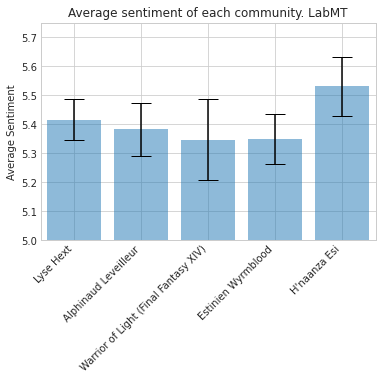

In [58]:
# Plot the results
communities_names = sentiment_community_all.keys()
x_pos = communities_names
CTEs = [np.mean(x) for x in sentiment_community_all.values()]
error = [np.std(x) for x in sentiment_community_all.values()]

plt.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(rotation=45, ha="right")
plt.axis([-0.5, 4.5, 5, 5.75])
plt.ylabel('Average Sentiment')
plt.title('Average sentiment of each community. LabMT')
plt.show()

As a result, all values are all between the value 5 and 6, meaning there is a slight positive average sentiment in all communities. The error bars do not show a great variance in the values, meaning that the character in every community take all similar values. We now proceed with the VADER analysis, using the Dialogue dataset.

#### 3.7.3. Sentiment Analysis 3

Data: Dialogues from the Videogame

Method: VADER

In [59]:
analyzer = SentimentIntensityAnalyzer()
sentiment_community_dict = {}
sentiment_community_all = {}
lemmatizer = WordNetLemmatizer()
for i in index_list_max:
    sumy = 0 
    length = 0
    for char in list(communities[i]):
        if char in list(dict1.keys()):
            # print('Community:',communities[i][0], '---> Character dialogue found:', char)        
            vs = analyzer.polarity_scores(dict1[char])
            sumy += vs['compound']
            length += 1 # calculate average of all the sentences of this character
            if communities[i][0] in list(sentiment_community_all.keys()):
                sentiment_community_all[communities[i][0]].append(vs['compound'])
            else:
                sentiment_community_all[communities[i][0]] = [] 
                sentiment_community_all[communities[i][0]].append(vs['compound'])
    sentiment_community_dict[communities[i][0]] = sumy/length

In [60]:
print('Average sentiment of the 5 greatest communities:')
sentiment_community_dict

Average sentiment of the 5 greatest communities:


{'Lyse Hext': 0.7295571428571429,
 'Alphinaud Leveilleur': 0.5454000000000001,
 'Warrior of Light (Final Fantasy XIV)': 0.83685,
 'Estinien Wyrmblood': 0.6580666666666667,
 "H'naanza Esi": 0.9311499999999999}

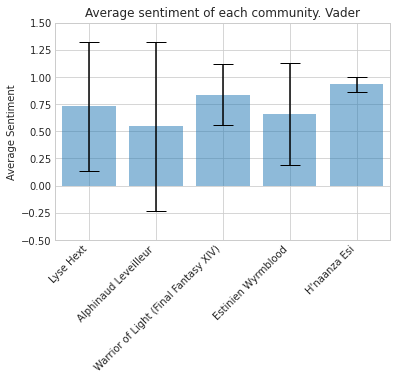

In [61]:
# Plotting the results
communities_names = sentiment_community_all.keys()
x_pos = communities_names
CTEs = [np.mean(x) for x in sentiment_community_all.values()]
error = [np.std(x) for x in sentiment_community_all.values()]

plt.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(rotation=45, ha="right")
plt.axis([-0.5, 4.5, -0.5, 1.5])
plt.ylabel('Average Sentiment')
plt.title('Average sentiment of each community. Vader')
plt.show()

The VADER analysis gives more interesting results. All communities scored a value greater than zero, that means the average sentiment is positive, in particular, the *Warrior of Light (Final Fantasy XIV)* 's community, scored 0.869, meaning a great positivity in the text. In this case we can also see from the error bars that there is much more variance in the characters of one community. For example, the *Lyse Hext* 's community scored the positive value 0.636 even though the error bars indicate at least one character got a negative result.

## 4. Discussion


We analyzed Final Fantasy XIV's character descriptions and dialogue in this project. After data extraction and preprocessing using the Final Fantasy Fandom Wiki's API and regular expressions, a directed network was built and found to be behaving as a sparse, scaled-free network. The most linked characters met our expectations based on knowledge of the game, as they are central characters with a significant influence on the plot and the outcomes of the game.

The communities found through the Louvain Algorithm have different relevant words, calculated using the TF-IDF algorithm, which could be caused by differences in the plot of the story for those groups of characters. The following sentiment analysis enabled us to study the positivity of the communities, and the differences of sentiment between the text descriptions of the characters and actual dialogues from the game. Using the LabMT database, the sentiment analyses resulted in a mild positive sentiment, both for the text description and for the dialogues, meaning either the words collected from the texts could not transpares the real feelings or the characters truly had a rather neutral sentiment. More interesting results were achieved through the VADER algorithm, that adding the punctuation to the analysis and studying the meaning of the whole sentences rather than the single words, managed to obtain a more realistic description of the feeling in the communities, although with higher variance amongst the characters. 

The analyses could be improved by adding more information for every character, for example more dialogues, or more backstories. In this way we would be able to better analyze the sentiment of each character and also create more accurate communities, that could be based on their characteristics instead of their connections. For the purpose of this project however, we are satisfied with the knowledge we managed to gather by studying the information that we had about the game, its characters and the their relations.

## 5. Contributions

Although all members contributed to every section, there were leads on significant portions of the project.

Rasim focused on the website due to his web development experience, while Saud and Matteo focused on notebook construction. Below is a more detailed breakdown:

1. **Rasim Deniz (s213225)**: Web design and deployment, Jupyter code review, and debugging

1. **Saud Abdulaziz A Shaheen (s213077)**: Data extraction and storage, preprocessing, and regular expression formation, network construction, and analysis

1. **Matteo Sabadin (s212980)**: Text analysis: word clouds, community detection, and sentiment analysis

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8f6f5ff7-c522-4b00-830d-73030439484f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>